In [3]:
# %load_ext autoreload
# %autoreload 2
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../../astro_tools')
sys.path.append('../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import wcs
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import ImageGrid
from reproject import reproject_interp
from astropy import units as u
from matplotlib.lines import Line2D
from spectral_cube import SpectralCube
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import take_slice
import routine
from astropy.wcs.utils import pixel_to_skycoord
import pvextractor
import cmasher as cmr

# set up the plot
plt.rcParams['text.usetex'] = False
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.5
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'
plt.rcParams["font.family"] = "courier new"
plt.rcParams["font.style"] = "normal"
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.weight"] = 'bold'



Afont = {
        'family' : 'courier new',
        'color':  'black',
        'size': 18,
        }

Afontw = {
        'family' : 'courier new',
        'color':  'white',
        'size': 22,
        }

In [17]:
def guesses_CO_SW(position, params):

    if position == 0.0:
        amp1 = 3
        vel1 = 250
        sig1 = 20
        amp2 = 1
        vel2 = 400
        sig2 = 20
        guess_list = [amp1,vel1,sig1,amp2,vel2,sig2]
        limits = None
        limited = [(False, False), (False, False), (False, False), 
                   (False, False), (False, False), (False, False)]
        
    else:
        guess_list = params
        limits = None
        limited = [(False, False), (False, False), (False, False), 
                   (False, False), (False, False), (False, False)]
    
    return guess_list, limits, limited



def line_flux(amp, sig):
    
    """
    
    Adopted from https://lukeholden.com/blog/measuring_emission_line_fluxes_python.html#measuring_line_fluxes
    
    """
    
    sig_Ang = (sig * 2.2) / 100
    
    flux = amp * sig_Ang * np.sqrt(2*np.pi)
#     flux_err = flux*np.sqrt((peak_err/peak)**2 + (width_err/width)**2)
    return flux

Extract the slices. Different slices from v4.

In [5]:
Vsys_center = 243.
Vsys_sw = 280.

# define the slice!
pa = 320+180  # measuring N-S
width_CO = 5.133*0.3  # pixels*arcsec/pixel
length1_CO = 34.*0.3 # pixels*arcsec/pixel

# ============================================================================================================
# ============================================================================================================
COfilename = '../../ngc253/muse/data/CO21_briggs_03aug2017_feather_SD1_newTP-flg-agr-vel2_19sep.fits'
velocity_convention = 'radio'
restfreq = 230.538 * u.GHz
ContUpper = 450
ContLower = 100

x1_CO_SW = 223.147
y1_CO_SW = 164.515
# extract the slice and the spectra along the slice
COslice1, path1CO, spectra_list1, COspatial_axis_arcsec1, velocity_axis = take_slice.slice_extractor(COfilename,
               x1_CO_SW, y1_CO_SW, length1_CO, pa, width_CO, velocity_convention, restfreq)

# x2_CO_SW = 223.147
# y2_CO_SW = 164.515
# # extract the slice and the spectra along the slice
# COslice2, path2CO, spectra_list2, COspatial_axis_arcsec2, velocity_axis = take_slice.slice_extractor(COfilename,
#                x2_CO_SW, y2_CO_SW, length2_CO, pa, width_CO, velocity_convention, restfreq)


# ============================================================================================================
# ============================================================================================================
NIIfilename = '../../ngc253/muse/data/ADP.2018-11-22T21_29_46.157.fits'
fits2_file = '../../ngc253/muse/Nov28/fits2_total/fits2_reordered.txt'
ERRfits2_file = '../../ngc253/muse/data/Nov28/fits2_total/fits2_err_reordered.txt'
NII = fits.open(NIIfilename)[1]
z, y, x = NII.data.shape

NII_amps_blue = fits.open('../../ngc253/muse/data/output_maps/ngc253_muse_se_niib_amp_outflow_blue.fits')
NII_amps_blue_3D = np.empty((1,NII_amps_blue[0].data.shape[0],NII_amps_blue[0].data.shape[1]))
NII_amps_blue_3D[:,:,:] = NII_amps_blue[0].data
NII_amps_cube = SpectralCube(NII_amps_blue_3D, wcs=wcs.WCS(NII))

NII_vels_blue = fits.open('../../ngc253/muse/data/output_maps/ngc253_muse_se_niib_vel_outflow_blue.fits')
NII_vels_blue_3D = np.empty((1,NII_vels_blue[0].data.shape[0],NII_vels_blue[0].data.shape[1]))
NII_vels_blue_3D[:,:,:] = NII_vels_blue[0].data
NII_vels_cube = SpectralCube(NII_vels_blue_3D, wcs=wcs.WCS(NII))

NII_fwhm_blue = fits.open('../../ngc253/muse/data/output_maps/ngc253_muse_se_niib_sig_outflow_blue.fits')
NII_fwhm_blue_3D = np.empty((1,NII_fwhm_blue[0].data.shape[0],NII_fwhm_blue[0].data.shape[1]))
NII_fwhm_blue_3D[:,:,:] = NII_fwhm_blue[0].data
NII_fwhm_cube = SpectralCube(NII_fwhm_blue_3D, wcs=wcs.WCS(NII))
# ------------------------------------------------------------------------------------------------------------

# extract the first slice
y1_NII_SW = 257
x1_NII_SW = 304
width_NII = 7.7*0.2  # pixels*arcsec/pixel
length1_NII = 51.*0.2 # pixels*arcsec/pixel

coord1 = pixel_to_skycoord(x1_NII_SW, y1_NII_SW, wcs=wcs.WCS(NII))
path1NII = pvextractor.PathFromCenter(center=coord1,
                    length=length1_NII * u.arcsec,
                    angle=pa * u.deg,
                    width=width_NII*u.arcsec)  # 10 pixels wide    
NIIslice1_vels = pvextractor.extract_pv_slice(cube=NII_vels_cube, path=path1NII)
NIIslice1_fwhm = pvextractor.extract_pv_slice(cube=NII_fwhm_cube, path=path1NII)

# grab each spectrum along the transverse axis (i.e., along the length of the slice)
NII_vels_list1 = [float(NIIslice1_vels.data[:,i]) for i in range(NIIslice1_vels.shape[1])]
NII_fwhm_list1 = [float(NIIslice1_fwhm.data[:,i]) for i in range(NIIslice1_fwhm.shape[1])]

# grab the spatial axis of the PV slice and convert from degrees to arcsec
NIIspatial_axis_deg1 = wcs.WCS(NIIslice1_vels.header).array_index_to_world_values(np.zeros(NIIslice1_vels.shape[1]), np.arange(NIIslice1_vels.shape[1]))
NIIspatial_axis_arcsec1 = (NIIspatial_axis_deg1[0] * u.deg).to(u.arcsec).to_value()

# ------------------------------------------------------------------------------------------------------------
y2_NII_SW = 260
x2_NII_SW = 275

length2_NII = 51.*0.2 # pixels*arcsec/pixel

coord2 = pixel_to_skycoord(x2_NII_SW, y2_NII_SW, wcs=wcs.WCS(NII))
path2NII = pvextractor.PathFromCenter(center=coord2,
                    length=length2_NII * u.arcsec,
                    angle=pa * u.deg,
                    width=width_NII*u.arcsec)  # 10 pixels wide    
NIIslice2_vels = pvextractor.extract_pv_slice(cube=NII_vels_cube, path=path2NII)
NIIslice2_fwhm = pvextractor.extract_pv_slice(cube=NII_fwhm_cube, path=path2NII)

# grab each spectrum along the transverse axis (i.e., along the length of the slice)
NII_vels_list2 = [float(NIIslice2_vels.data[:,i]) for i in range(NIIslice2_vels.shape[1])]
NII_fwhm_list2 = [float(NIIslice2_fwhm.data[:,i]) for i in range(NIIslice2_fwhm.shape[1])]

# grab the spatial axis of the PV slice and convert from degrees to arcsec
NIIspatial_axis_deg2 = wcs.WCS(NIIslice2_vels.header).array_index_to_world_values(np.zeros(NIIslice2_vels.shape[1]), np.arange(NIIslice2_vels.shape[1]))
NIIspatial_axis_arcsec2 = (NIIspatial_axis_deg2[0] * u.deg).to(u.arcsec).to_value()

# ------------------------------------------------------------------------------------------------------------
y3_NII_SW = 260
x3_NII_SW = 240

length3_NII = 51.*0.2 # pixels*arcsec/pixel

coord3 = pixel_to_skycoord(x3_NII_SW, y3_NII_SW, wcs=wcs.WCS(NII))
path3NII = pvextractor.PathFromCenter(center=coord3,
                    length=length3_NII * u.arcsec,
                    angle=pa * u.deg,
                    width=width_NII*u.arcsec)  # 10 pixels wide    
NIIslice3_vels = pvextractor.extract_pv_slice(cube=NII_vels_cube, path=path3NII)
NIIslice3_fwhm = pvextractor.extract_pv_slice(cube=NII_fwhm_cube, path=path3NII)

# grab each spectrum along the transverse axis (i.e., along the length of the slice)
NII_vels_list3 = [float(NIIslice3_vels.data[:,i]) for i in range(NIIslice3_vels.shape[1])]
NII_fwhm_list3 = [float(NIIslice3_fwhm.data[:,i]) for i in range(NIIslice3_fwhm.shape[1])]

# grab the spatial axis of the PV slice and convert from degrees to arcsec
NIIspatial_axis_deg3 = wcs.WCS(NIIslice3_vels.header).array_index_to_world_values(np.zeros(NIIslice3_vels.shape[1]), np.arange(NIIslice3_vels.shape[1]))
NIIspatial_axis_arcsec3 = (NIIspatial_axis_deg3[0] * u.deg).to(u.arcsec).to_value()

# ------------------------------------------------------------------------------------------------------------
y4_NII_SW = 250
x4_NII_SW = 185

length4_NII = 51.*0.2 # pixels*arcsec/pixel
pa4 = 310+180  # measuring N-S

coord4 = pixel_to_skycoord(x4_NII_SW, y4_NII_SW, wcs=wcs.WCS(NII))
path4NII = pvextractor.PathFromCenter(center=coord4,
                    length=length4_NII * u.arcsec,
                    angle=pa4 * u.deg,
                    width=width_NII*u.arcsec)  # 10 pixels wide    
NIIslice4_vels = pvextractor.extract_pv_slice(cube=NII_vels_cube, path=path4NII)
NIIslice4_fwhm = pvextractor.extract_pv_slice(cube=NII_fwhm_cube, path=path4NII)

# grab each spectrum along the transverse axis (i.e., along the length of the slice)
NII_vels_list4 = [float(NIIslice4_vels.data[:,i]) for i in range(NIIslice4_vels.shape[1])]
NII_fwhm_list4 = [float(NIIslice4_fwhm.data[:,i]) for i in range(NIIslice4_fwhm.shape[1])]

# grab the spatial axis of the PV slice and convert from degrees to arcsec
NIIspatial_axis_deg4 = wcs.WCS(NIIslice4_vels.header).array_index_to_world_values(np.zeros(NIIslice4_vels.shape[1]), np.arange(NIIslice3_vels.shape[1]))
NIIspatial_axis_arcsec4 = (NIIspatial_axis_deg4
                           [0] * u.deg).to(u.arcsec).to_value()

# ------------------------------------------------------------------------------------------------------------
y5_NII_SW = 130
x5_NII_SW = 200

length5_NII = 51.*0.2 # pixels*arcsec/pixel
pa5 = 320+180  # measuring N-S

coord5 = pixel_to_skycoord(x5_NII_SW, y5_NII_SW, wcs=wcs.WCS(NII))
path5NII = pvextractor.PathFromCenter(center=coord5,
                    length=length5_NII * u.arcsec,
                    angle=pa5 * u.deg,
                    width=width_NII*u.arcsec)  # 10 pixels wide    
NIIslice5_vels = pvextractor.extract_pv_slice(cube=NII_vels_cube, path=path5NII)
NIIslice5_fwhm = pvextractor.extract_pv_slice(cube=NII_fwhm_cube, path=path5NII)

# grab each spectrum along the transverse axis (i.e., along the length of the slice)
NII_vels_list5 = [float(NIIslice5_vels.data[:,i]) for i in range(NIIslice5_vels.shape[1])]
NII_fwhm_list5 = [float(NIIslice5_fwhm.data[:,i]) for i in range(NIIslice5_fwhm.shape[1])]

# grab the spatial axis of the PV slice and convert from degrees to arcsec
NIIspatial_axis_deg5 = wcs.WCS(NIIslice5_vels.header).array_index_to_world_values(np.zeros(NIIslice5_vels.shape[1]), np.arange(NIIslice3_vels.shape[1]))
NIIspatial_axis_arcsec5 = (NIIspatial_axis_deg5
                           [0] * u.deg).to(u.arcsec).to_value()

# divide the vels*amps by sum of the amps
NIIslice5_amps = pvextractor.extract_pv_slice(cube=NII_amps_cube, path=path5NII)
NII_amps_list5 = [float(NIIslice5_amps.data[:,i]) for i in range(NIIslice5_amps.shape[1])]
NII_weighted_vels_list5 = np.array(NII_vels_list5) / np.array(NII_amps_list5)



In [6]:
NIIslice1_vels.writeto('../../ngc253/muse/data/output_maps/NIIslice1test.fits', overwrite=True)  
COslice1.writeto('../../ngc253/muse/data/output_maps/COslice1test.fits', overwrite=True)  

Plot the slices.

In [7]:
def get_offset(dat, w):
    
    center_pix = w.pixel_to_world(dat.shape[1]//2, dat.shape[0]//2)
    
    ra_hr = center_pix.ra.hms[0]
    ra_min = center_pix.ra.hms[1]
    ra_sec = center_pix.ra.hms[2]
    ra_hms = '%s$^{h}$%s$^{m}$%s$^{s}$' % (int(ra_hr), int(ra_min), np.round(ra_sec,2))
    
    dec_deg = center_pix.dec.dms[0]
    dec_min = center_pix.dec.dms[1]
    dec_sec = center_pix.dec.dms[2]
    dec_dms = "%s$^{o}$%s'%s$''$" % (int(dec_deg), int(np.abs(dec_min)), np.round(np.abs(dec_sec),2))

    return(ra_hms, dec_dms)

In [8]:
ra_hms, dec_dms = get_offset(NII.data, wcs.WCS(NII.header, naxis=2).celestial)
pixscale = 0.2  # arcsec
x_lower = -(NII.shape[2]*pixscale)//2
x_upper = (NII.shape[2]*pixscale)//2
y_lower = -(NII.shape[1]*pixscale)//2
y_upper = (NII.shape[1]*pixscale)//2
extent=[x_lower,x_upper, y_lower,y_upper]


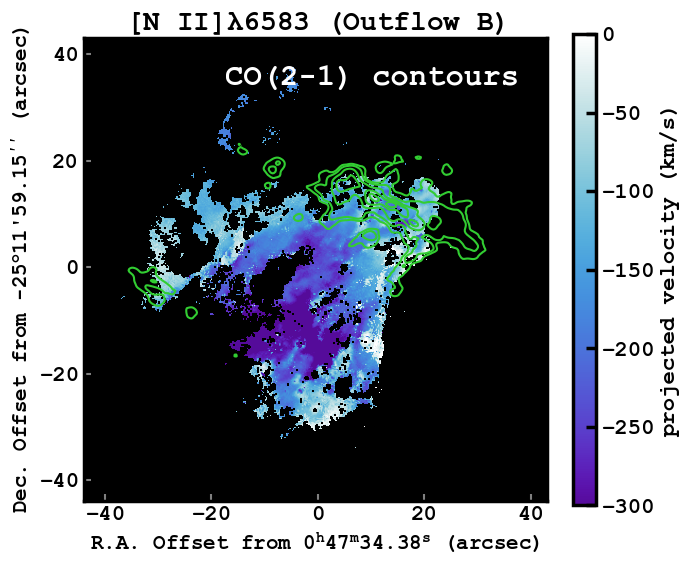

In [9]:
cmap = cmr.get_sub_cmap('cmr.fusion_r', 0.1, 0.50)

# ============================================================================================================
# ============================================================================================================
CO21_cube = SpectralCube.read(COfilename)
CO21 = CO21_cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=restfreq)  
CO21_chan = CO21[53,:,:].to_value()
# CO21_mom0 = CO21.moment(order=0).to_value()  # moment 0
# CO21_mom1 = CO21.moment(order=1).to_value()
CO21w = CO21[0,:,:].wcs

plt.figure(figsize=(7,7))


# ============================================================================================================
# ============================================================================================================

# ax = plt.subplot(1, 1, 1, projection=wcs.WCS(NII, naxis=2))
ax = plt.subplot(1, 1, 1)
im = ax.imshow(NII_vels_blue_3D[0,:,:], origin='lower', vmin=-300, vmax=0, cmap=cmap,extent=extent)
ax.set_title('', fontsize=18)
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=16, length=5, color='gray')
ax.set_xlabel('R.A.', fontsize=20)
# ax.set_xlim(140, 140+252)
# ax.set_ylim(175, 175+252)

# ax.contour(CO21_chan, transform=ax.get_transform(CO21w),lw=5,
#            levels=[-0.0223731, 0.1, 0.2, 0.606325, 1.23502, 1.86372, 2.49242], 
#            colors='limegreen',zorder=0)

ax.contour(CO21_chan, extent=extent,lw=5,
           levels=[-0.0223731, 0.1, 0.2, 0.606325, 1.23502, 1.86372, 2.49242], 
           colors='limegreen',zorder=0)

from matplotlib.patches import Rectangle
# path1NII.show_on_axis(ax, spacing=5, edgecolor='white', linestyle='-',
#                       linewidth=2)
# path2NII.show_on_axis(ax, spacing=5, edgecolor='white', linestyle='-',
#                       linewidth=2)
# path3NII.show_on_axis(ax, spacing=5, edgecolor='white', linestyle='-',
#                       linewidth=2)
# path4NII.show_on_axis(ax, spacing=5, edgecolor='white', linestyle='-',
#                       linewidth=2)
# path5NII.show_on_axis(ax, spacing=5, edgecolor='white', linestyle='-',
#                       linewidth=2)


bar = plt.colorbar(im, fraction=0.046)
bar.set_label('projected velocity (km/s)', fontsize=16)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')

ax.set_title('[N II]$\lambda 6583$ (Outflow B)', fontsize=20)

at = AnchoredText('CO(2-1) contours', prop=Afontw, frameon=False, 
                  loc='upper right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
ax.set_facecolor('black')

ax.set_xlabel('R.A. Offset from %s (arcsec)' % ra_hms, fontsize=15)
ax.set_ylabel('Dec. Offset from %s (arcsec)' % dec_dms, fontsize=15)
# ax.coords[0].set_major_formatter('d.ddd')
# ax.coords[1].set_major_formatter('d.ddd')
# ax.coords[1].set_auto_axislabel(False)
# ax.coords[1].set_ticks([-40, -20, 0, 20, 40] * u.arcsec)
# ax.coords[0].set_ticks([-40, -20, 0, 20, 40] * u.arcsec)
ax.set_yticks([-40, -20, 0, 20, 40])

# ============================================================================================================
# ============================================================================================================

plt.annotate('1', xy=(310, 240), fontsize=13, color='white', rotation=0, 
             bbox=dict(facecolor='gray', edgecolor='gray', boxstyle='round'))
plt.annotate('2', xy=(250, 220), fontsize=13, color='white', rotation=0,
            bbox=dict(facecolor='gray', edgecolor='gray', boxstyle='round'))
plt.annotate('3', xy=(210, 220), fontsize=13, color='white', rotation=0,
            bbox=dict(facecolor='gray', edgecolor='gray', boxstyle='round'))
plt.annotate('4', xy=(150, 220), fontsize=13, color='white', rotation=0,
            bbox=dict(facecolor='gray', edgecolor='gray', boxstyle='round'))
plt.annotate('5', xy=(165, 120), fontsize=13, color='white', rotation=0,
            bbox=dict(facecolor='gray', edgecolor='gray', boxstyle='round'))

# one = Rectangle((x1_NII_SW, y1_NII_SW), width_NII/0.2, length1_NII/0.2, angle=pa, rotation_point='xy', color='pink')
# ax.add_artist(one)

# plt.subplots_adjust(wspace=12, hspace=0)
plt.tight_layout()
plt.savefig('../../ngc253/muse/visuals/se_co_outb_Dec18_Part2.png', bbox_inches='tight', dpi=200)
plt.show()

Fit CO along each slice.

In [10]:
# extract the slice and the spectra along the slice
savepath1 = '../../ngc253/muse/Nov28/CO/slice1'
COslice1, path1CO, spectra_list1, COspatial_axis_arcsec1, velocity_axis = take_slice.slice_extractor(COfilename,
               x1_CO_SW, y1_CO_SW, length1_CO, pa, width_CO, velocity_convention, restfreq)

# generate the text files we want
take_slice.generate_text_files(savepath1)

# run the gaussian fitter to extract velocities
take_slice.velocity_extractor(savepath1, guesses_CO_SW, spectra_list1, COspatial_axis_arcsec1, 
                   velocity_axis, ContUpper, ContLower)

# grab velocities and errors from text files
CO_amps1, CO_amp_errs1, CO_vels1, CO_vel_errs1, CO_sigs1, CO_sig_errs1 = take_slice.extract_blue_velocities(savepath1)

Now let's weight the velocities of [N II] by intensity.

In [11]:
# weight the velocities by intensity
NII_vels_blue_file = fits.open('../../ngc253/muse/data/output_maps/ngc253_muse_se_niib_vel_outflow_blue.fits')
NII_amps_blue_file = fits.open('../../ngc253/muse/data/output_maps/ngc253_muse_se_niib_amp_outflow_blue.fits')
NII_vels_blue = np.nan_to_num(NII_vels_blue_file[0].data)
NII_amps_blue = np.nan_to_num(NII_amps_blue_file[0].data)

# NII_vels_blue[np.isnan(NII_vels_blue)] = 0.
# norm = (NII_amps_blue-np.min(NII_amps_blue))/(np.max(NII_amps_blue)-np.min(NII_amps_blue))
# NII_weighted_vels = (NII_vels_blue * norm)
# NII_weighted_vels[np.isnan(NII_vels_blue_file[0].data)] = np.nan  # get the nans back baybeeeeee

# numerator to the weighted velocities; amplitude * velocity
NII_weighted_vels = NII_amps_blue * NII_vels_blue
hdul = fits.PrimaryHDU(data=NII_weighted_vels, header=NII.header)
hdul.writeto('../../ngc253/muse/data/output_maps/ngc253_muse_se_niib_weightedvel_outflow_blue.fits',  overwrite=True)

# ============================================================================================================
# ============================================================================================================

# # do the same for the errors
# NII_vels_blue_file_ERR = fits.open('../ngc253/data/output_maps/ngc253_muse_se_niib_vel_outflow_blue_ERR.fits')
# NII_amps_blue_file_ERR = fits.open('../ngc253/data/output_maps/ngc253_muse_se_niib_amp_outflow_blue_ERR.fits')
# NII_vels_blue_ERR = np.nan_to_num(NII_vels_blue_file_ERR[0].data)
# NII_amps_blue_ERR = np.nan_to_num(NII_amps_blue_file_ERR[0].data)

# norm_ERR = (NII_amps_blue_ERR-np.min(NII_amps_blue_ERR))/(np.max(NII_amps_blue_ERR)-np.min(NII_amps_blue_ERR))
# NII_weighted_vels_ERR = (NII_vels_blue_ERR * norm_ERR)
# NII_weighted_vels_ERR[np.isnan(NII_vels_blue_file_ERR[0].data)] = np.nan

# hdul = fits.PrimaryHDU(data=NII_weighted_vels_ERR, header=NII.header)
# hdul.writeto('../ngc253/data/output_maps/ngc253_muse_se_niib_weightedvel_outflow_blue_ERR.fits',  overwrite=True)

In [12]:
# define the slice!
pa = 320+180  # measuring N-S

# ============================================================================================================
# ============================================================================================================
COfilename = '../../ngc253/muse/data/CO21_briggs_03aug2017_feather_SD1_newTP-flg-agr-vel2_19sep.fits'
velocity_convention = 'radio'
restfreq = 230.538 * u.GHz
ContUpper = 450
ContLower = 100

x1_CO_SW = 223.147
y1_CO_SW = 164.515

width_CO = 5.133*0.3  # pixels*arcsec/pixel
length1_CO = 34.*0.3 # pixels*arcsec/pixel

# extract the slice and the spectra along the slice
COslice1, path1CO, spectra_list1, COspatial_axis_arcsec1, velocity_axis = take_slice.slice_extractor(COfilename,
               x1_CO_SW, y1_CO_SW, length1_CO, pa, width_CO, velocity_convention, restfreq)


# ============================================================================================================
# ============================================================================================================
NII_vels_blue = fits.open('../../ngc253/muse/data/output_maps/ngc253_muse_se_niib_weightedvel_outflow_blue.fits')
NII_vels_blue_3D = np.empty((1,NII_vels_blue[0].data.shape[0],NII_vels_blue[0].data.shape[1]))
NII_vels_blue_3D[:,:,:] = NII_vels_blue[0].data
NII_vels_cube = SpectralCube(NII_vels_blue_3D, wcs=wcs.WCS(NII))

# also extract the amplitudes
NII_amps_blue = fits.open('../../ngc253/muse/data/output_maps/ngc253_muse_se_niib_amp_outflow_blue.fits')
NII_amps_blue_3D = np.empty((1,NII_amps_blue[0].data.shape[0],NII_amps_blue[0].data.shape[1]))
NII_amps_blue_3D[:,:,:] = NII_amps_blue[0].data
NII_amps_cube = SpectralCube(NII_amps_blue_3D, wcs=wcs.WCS(NII))

# aaaand grab the hbeta/halpha ratio
rat_file = fits.open('../../ngc253/muse/data/hbeta_halpha_intens.fits')
rat_3D = np.empty((1,rat_file[0].data.shape[0],rat_file[0].data.shape[1]))
rat_3D[:,:,:] = rat_file[0].data
rat_cube = SpectralCube(rat_3D, wcs=wcs.WCS(NII))
# ------------------------------------------------------------------------------------------------------------

# extract the first slice
y1_NII_SW = 257.46
x1_NII_SW = 304.04
width_NII = 7.7*0.2  # pixels*arcsec/pixel
length1_NII = 51.*0.2 # pixels*arcsec/pixel

coord1 = pixel_to_skycoord(x1_NII_SW, y1_NII_SW, wcs=wcs.WCS(NII))
path1NII = pvextractor.PathFromCenter(center=coord1,
                    length=length1_NII * u.arcsec,
                    angle=pa * u.deg,
                    width=width_NII*u.arcsec)  # 10 pixels wide    
NIIslice1 = pvextractor.extract_pv_slice(cube=NII_vels_cube, path=path1NII)

# grab each spectrum along the transverse axis (i.e., along the length of the slice)
NII_vels_list1 = [float(NIIslice1.data[:,i]) for i in range(NIIslice1.shape[1])]

# grab the spatial axis of the PV slice and convert from degrees to arcsec
NIIspatial_axis_deg1 = wcs.WCS(NIIslice1.header).array_index_to_world_values(np.zeros(NIIslice1.shape[1]), np.arange(NIIslice1.shape[1]))
NIIspatial_axis_arcsec1 = (NIIspatial_axis_deg1[0] * u.deg).to(u.arcsec).to_value()

# divide the vels*amps by sum of the amps
NIIslice1_amps = pvextractor.extract_pv_slice(cube=NII_amps_cube, path=path1NII)
NII_amps_list1 = [float(NIIslice1_amps.data[:,i]) for i in range(NIIslice1_amps.shape[1])]
NII_weighted_vels_list1 = np.array(NII_vels_list1) / np.array(NII_amps_list1)


# ------------------------------------------------------------------------------------------------------------
y2_NII_SW = 260
x2_NII_SW = 275

length2_NII = 51.*0.2 # pixels*arcsec/pixel

coord2 = pixel_to_skycoord(x2_NII_SW, y2_NII_SW, wcs=wcs.WCS(NII))
path2NII = pvextractor.PathFromCenter(center=coord2,
                    length=length2_NII * u.arcsec,
                    angle=pa * u.deg,
                    width=width_NII*u.arcsec)  # 10 pixels wide    
NIIslice2_vels = pvextractor.extract_pv_slice(cube=NII_vels_cube, path=path2NII)
NIIslice2_fwhm = pvextractor.extract_pv_slice(cube=NII_fwhm_cube, path=path2NII)

# grab each spectrum along the transverse axis (i.e., along the length of the slice)
NII_vels_list2 = [float(NIIslice2_vels.data[:,i]) for i in range(NIIslice2_vels.shape[1])]
NII_fwhm_list2 = [float(NIIslice2_fwhm.data[:,i]) for i in range(NIIslice2_fwhm.shape[1])]

# grab the spatial axis of the PV slice and convert from degrees to arcsec
NIIspatial_axis_deg2 = wcs.WCS(NIIslice2_vels.header).array_index_to_world_values(np.zeros(NIIslice2_vels.shape[1]), np.arange(NIIslice2_vels.shape[1]))
NIIspatial_axis_arcsec2 = (NIIspatial_axis_deg2[0] * u.deg).to(u.arcsec).to_value()

# divide the vels*amps by sum of the amps
NIIslice2_amps = pvextractor.extract_pv_slice(cube=NII_amps_cube, path=path2NII)
NII_amps_list2 = [float(NIIslice2_amps.data[:,i]) for i in range(NIIslice2_amps.shape[1])]
NII_weighted_vels_list2 = np.array(NII_vels_list2) / np.array(NII_amps_list2)


# ------------------------------------------------------------------------------------------------------------
y3_NII_SW = 260
x3_NII_SW = 240

length3_NII = 51.*0.2 # pixels*arcsec/pixel

coord3 = pixel_to_skycoord(x3_NII_SW, y3_NII_SW, wcs=wcs.WCS(NII))
path3NII = pvextractor.PathFromCenter(center=coord3,
                    length=length3_NII * u.arcsec,
                    angle=pa * u.deg,
                    width=width_NII*u.arcsec)  # 10 pixels wide    
NIIslice3_vels = pvextractor.extract_pv_slice(cube=NII_vels_cube, path=path3NII)
NIIslice3_fwhm = pvextractor.extract_pv_slice(cube=NII_fwhm_cube, path=path3NII)

# grab each spectrum along the transverse axis (i.e., along the length of the slice)
NII_vels_list3 = [float(NIIslice3_vels.data[:,i]) for i in range(NIIslice3_vels.shape[1])]
NII_fwhm_list3 = [float(NIIslice3_fwhm.data[:,i]) for i in range(NIIslice3_fwhm.shape[1])]

# grab the spatial axis of the PV slice and convert from degrees to arcsec
NIIspatial_axis_deg3 = wcs.WCS(NIIslice3_vels.header).array_index_to_world_values(np.zeros(NIIslice3_vels.shape[1]), np.arange(NIIslice3_vels.shape[1]))
NIIspatial_axis_arcsec3 = (NIIspatial_axis_deg3[0] * u.deg).to(u.arcsec).to_value()


# divide the vels*amps by sum of the amps
NIIslice3_amps = pvextractor.extract_pv_slice(cube=NII_amps_cube, path=path3NII)
NII_amps_list3 = [float(NIIslice3_amps.data[:,i]) for i in range(NIIslice3_amps.shape[1])]
NII_weighted_vels_list3 = np.array(NII_vels_list3) / np.array(NII_amps_list3)

# ------------------------------------------------------------------------------------------------------------
y4_NII_SW = 250
x4_NII_SW = 185

length4_NII = 51.*0.2 # pixels*arcsec/pixel
pa4 = 310+180  # measuring N-S

coord4 = pixel_to_skycoord(x4_NII_SW, y4_NII_SW, wcs=wcs.WCS(NII))
path4NII = pvextractor.PathFromCenter(center=coord4,
                    length=length4_NII * u.arcsec,
                    angle=pa4 * u.deg,
                    width=width_NII*u.arcsec)  # 10 pixels wide    
NIIslice4_vels = pvextractor.extract_pv_slice(cube=NII_vels_cube, path=path4NII)
NIIslice4_fwhm = pvextractor.extract_pv_slice(cube=NII_fwhm_cube, path=path4NII)

# grab each spectrum along the transverse axis (i.e., along the length of the slice)
NII_vels_list4 = [float(NIIslice4_vels.data[:,i]) for i in range(NIIslice4_vels.shape[1])]
NII_fwhm_list4 = [float(NIIslice4_fwhm.data[:,i]) for i in range(NIIslice4_fwhm.shape[1])]

# grab the spatial axis of the PV slice and convert from degrees to arcsec
NIIspatial_axis_deg4 = wcs.WCS(NIIslice4_vels.header).array_index_to_world_values(np.zeros(NIIslice4_vels.shape[1]), np.arange(NIIslice4_vels.shape[1]))
NIIspatial_axis_arcsec4 = (NIIspatial_axis_deg4
                           [0] * u.deg).to(u.arcsec).to_value()

# divide the vels*amps by sum of the amps
NIIslice4_amps = pvextractor.extract_pv_slice(cube=NII_amps_cube, path=path4NII)
NII_amps_list4 = [float(NIIslice4_amps.data[:,i]) for i in range(NIIslice4_amps.shape[1])]
NII_weighted_vels_list4 = np.array(NII_vels_list4) / np.array(NII_amps_list4)

# ------------------------------------------------------------------------------------------------------------
y5_NII_SW = 130
x5_NII_SW = 200

length5_NII = 51.*0.2 # pixels*arcsec/pixel
pa5 = 320+180  # measuring N-S

coord5 = pixel_to_skycoord(x5_NII_SW, y5_NII_SW, wcs=wcs.WCS(NII))
path5NII = pvextractor.PathFromCenter(center=coord5,
                    length=length5_NII * u.arcsec,
                    angle=pa5 * u.deg,
                    width=width_NII*u.arcsec)  # 10 pixels wide    
NIIslice5_vels = pvextractor.extract_pv_slice(cube=NII_vels_cube, path=path5NII)
NIIslice5_fwhm = pvextractor.extract_pv_slice(cube=NII_fwhm_cube, path=path5NII)

# grab each spectrum along the transverse axis (i.e., along the length of the slice)
NII_vels_list5 = [float(NIIslice5_vels.data[:,i]) for i in range(NIIslice5_vels.shape[1])]
NII_fwhm_list5 = [float(NIIslice5_fwhm.data[:,i]) for i in range(NIIslice5_fwhm.shape[1])]

# grab the spatial axis of the PV slice and convert from degrees to arcsec
NIIspatial_axis_deg5 = wcs.WCS(NIIslice5_vels.header).array_index_to_world_values(np.zeros(NIIslice5_vels.shape[1]), np.arange(NIIslice5_vels.shape[1]))
NIIspatial_axis_arcsec5 = (NIIspatial_axis_deg5
                           [0] * u.deg).to(u.arcsec).to_value()

# divide the vels*amps by sum of the amps
NIIslice5_amps = pvextractor.extract_pv_slice(cube=NII_amps_cube, path=path5NII)
NII_amps_list5 = [float(NIIslice5_amps.data[:,i]) for i in range(NIIslice5_amps.shape[1])]
NII_weighted_vels_list5 = np.array(NII_vels_list5) / np.array(NII_amps_list5)


# ============================================================================================================
# ============================================================================================================
# also extract from the hbeta to halpha ratio
rat_slice1 = pvextractor.extract_pv_slice(cube=rat_cube, path=path1NII)

# grab each spectrum along the transverse axis (i.e., along the length of the slice)
rat_list1 = [float(rat_slice1.data[:,i]) for i in range(rat_slice1.shape[1])]

# and do again for the adjacent slice
rat_slice2 = pvextractor.extract_pv_slice(cube=rat_cube, path=path2NII)

# grab each spectrum along the transverse axis (i.e., along the length of the slice)
rat_list2 = [float(rat_slice2.data[:,i]) for i in range(rat_slice2.shape[1])]

# slice 3
rat_slice3 = pvextractor.extract_pv_slice(cube=rat_cube, path=path3NII)

# grab each spectrum along the transverse axis (i.e., along the length of the slice)
rat_list3 = [float(rat_slice3.data[:,i]) for i in range(rat_slice3.shape[1])]

# slice 4
rat_slice4 = pvextractor.extract_pv_slice(cube=rat_cube, path=path4NII)

# grab each spectrum along the transverse axis (i.e., along the length of the slice)
rat_list4 = [float(rat_slice4.data[:,i]) for i in range(rat_slice4.shape[1])]

# slice 5
rat_slice5 = pvextractor.extract_pv_slice(cube=rat_cube, path=path5NII)

# grab each spectrum along the transverse axis (i.e., along the length of the slice)
rat_list5 = [float(rat_slice5.data[:,i]) for i in range(rat_slice5.shape[1])]


In [13]:
# want to convert CO radio to optical velocities.
opt_doppler_equiv = u.doppler_optical(restfreq)  # equivalencies
rad_doppler_equiv = u.doppler_radio(restfreq)

CO slope from 1.5 - 4 arcsec is -4.693553580366324
NII slope from 1.5 - 4 arcsec is -47.902452956370645


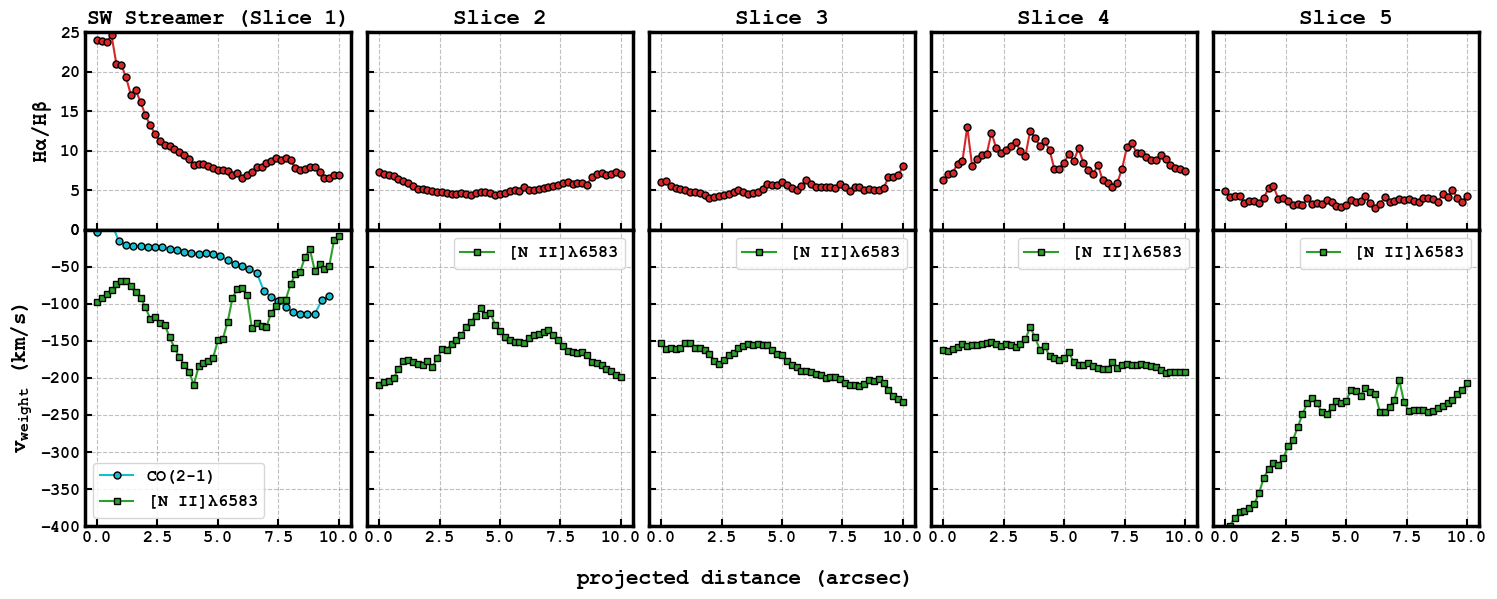

In [14]:
#f, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 5), gridspec_kw={'height_ratios': [2,3]})
# f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(8, 6), gridspec_kw={'height_ratios': [2,3]})
f, ((ax1, ax2, ax3, ax4, ax5),(ax6,ax7,ax8,ax9,ax10)) = plt.subplots(2, 5, figsize=(15, 6), 
                                                           gridspec_kw={'height_ratios': [2,3]}, 
                                                           sharex=True, sharey='row')

# ==============================================================================
# SW STREAMER
# ==============================================================================

# ------------------------------------------------------------------------------
# inds = (COspatial_axis_arcsec1 > 1.5)
inds_fit_lim = (COspatial_axis_arcsec1 > 1.5) & (COspatial_axis_arcsec1 < 4.)  # limit for just fitting
CO_vels_Vsys1 = (np.array(CO_vels1) - Vsys_sw) * u.km/u.s
freq_arr = CO_vels_Vsys1.to(u.GHz, rad_doppler_equiv)  # get radio frequencies 
CO_opt_vels_Vsys1 = freq_arr.to(u.km / u.s, equivalencies=opt_doppler_equiv)  # convert radio freq -> opt vel 
m1,b1 = np.polyfit(COspatial_axis_arcsec1[inds_fit_lim], CO_opt_vels_Vsys1[inds_fit_lim], 1) # best fit line
ax6.plot(COspatial_axis_arcsec1, CO_opt_vels_Vsys1, 'o-', markeredgecolor='black', ms=5, 
         label='CO(2-1)', color='tab:cyan')

print('CO slope from 1.5 - 4 arcsec is', m1)

# ------------------------------------------------------------------------------
# inds = (NIIspatial_axis_arcsec1 > 1.5)
inds_fit_lim = (NIIspatial_axis_arcsec1 > 1.5) & (NIIspatial_axis_arcsec1 < 4.)  # limit for just fitting
NII_sw_vels_Vsys1 = np.array(NII_weighted_vels_list1)
m1,b1 = np.polyfit(NIIspatial_axis_arcsec1[inds_fit_lim], NII_sw_vels_Vsys1[inds_fit_lim], 1) # best fit line
ax6.plot(NIIspatial_axis_arcsec1, NII_sw_vels_Vsys1, 's-', markeredgecolor='black', ms=5, 
         label='[N II]$\lambda 6583$', color='tab:green')
ax6.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
ax6.grid(ls='--',color='gray', alpha=0.5)
ax6.set_ylabel('v$_{weight}$ (km/s)', fontsize=15)
ax6.set_ylim(-400,0)
ax6.legend(fontsize=12)

print('NII slope from 1.5 - 4 arcsec is', m1)

# ------------------------------------------------------------------------------
### add the hbeta/halpha ratio values along this slice
hbeta_halpha_rat = np.array(rat_list1)
ax1.plot(NIIspatial_axis_arcsec1, 1/hbeta_halpha_rat, '.-', markeredgecolor='black', ms=10, color='tab:red')
ax1.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
ax1.set_ylabel(r'H$\alpha$/H$\beta$', fontsize=15)
ax1.grid(ls='--',color='gray', alpha=0.5)
ax1.set_ylim(0,25)

ax1.set_title('SW Streamer (Slice 1)', fontsize=15)

# ==============================================================================
# ADJACENT TO STREAMER (SLICE 2)
# ==============================================================================
# inds = (NIIspatial_axis_arcsec1 > 1.5)
# inds_fit_lim = (NIIspatial_axis_arcsec1 > 1.5) & (NIIspatial_axis_arcsec1 < 4.)  # limit for just fitting
NII_sw_vels_Vsys2 = np.array(NII_weighted_vels_list2)
m2,b2 = np.polyfit(NIIspatial_axis_arcsec2, NII_sw_vels_Vsys2, 1) # best fit line
ax7.plot(NIIspatial_axis_arcsec2, NII_sw_vels_Vsys2, 's-', markeredgecolor='black', ms=5, 
         label='[N II]$\lambda 6583$', color='tab:green')
ax7.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
ax7.set_ylim(-400,0)
ax7.grid(ls='--',color='gray', alpha=0.5)
ax7.legend(fontsize=12)

# ------------------------------------------------------------------------------
### add the hbeta/halpha ratio values along this slice
hbeta_halpha_rat2 = np.array(rat_list2)
ax2.plot(NIIspatial_axis_arcsec2, 1/hbeta_halpha_rat2, '.-', markeredgecolor='black', ms=10, color='tab:red')
ax2.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
ax2.grid(ls='--',color='gray', alpha=0.5)
ax2.set_title('Slice 2', fontsize=16)
ax2.set_ylim(0,25)

# ==============================================================================
# SLICE 3
# ==============================================================================
# inds = (NIIspatial_axis_arcsec1 > 1.5)
# inds_fit_lim = (NIIspatial_axis_arcsec1 > 1.5) & (NIIspatial_axis_arcsec1 < 4.)  # limit for just fitting
NII_sw_vels_Vsys3 = np.array(NII_weighted_vels_list3)
m3,b3 = np.polyfit(NIIspatial_axis_arcsec3, NII_sw_vels_Vsys3, 1) # best fit line
ax8.plot(NIIspatial_axis_arcsec3, NII_sw_vels_Vsys3, 's-', markeredgecolor='black', ms=5, 
         label='[N II]$\lambda 6583$', color='tab:green')
ax8.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
ax8.set_ylim(-400,0)
ax8.grid(ls='--',color='gray', alpha=0.5)
ax8.legend(fontsize=12)

# ------------------------------------------------------------------------------
### add the hbeta/halpha ratio values along this slice
hbeta_halpha_rat3 = np.array(rat_list3)
ax3.plot(NIIspatial_axis_arcsec3, 1/hbeta_halpha_rat3, '.-', markeredgecolor='black', ms=10, color='tab:red')
ax3.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
ax3.grid(ls='--',color='gray', alpha=0.5)
ax3.set_title('Slice 3', fontsize=16)
ax3.set_ylim(0,25)

# ==============================================================================
# SLICE 4
# ==============================================================================
# inds = (NIIspatial_axis_arcsec1 > 1.5)
# inds_fit_lim = (NIIspatial_axis_arcsec1 > 1.5) & (NIIspatial_axis_arcsec1 < 4.)  # limit for just fitting
NII_sw_vels_Vsys4 = np.array(NII_weighted_vels_list4)
m4,b4 = np.polyfit(NIIspatial_axis_arcsec4, NII_sw_vels_Vsys4, 1) # best fit line
ax9.plot(NIIspatial_axis_arcsec4, NII_sw_vels_Vsys4, 's-', markeredgecolor='black', ms=5, 
         label='[N II]$\lambda 6583$', color='tab:green')
ax9.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
ax9.set_ylim(-400,0)
ax9.grid(ls='--',color='gray', alpha=0.5)
ax9.legend(fontsize=12)

# ------------------------------------------------------------------------------
### add the hbeta/halpha ratio values along this slice
hbeta_halpha_rat4 = np.array(rat_list4)
ax4.plot(NIIspatial_axis_arcsec4, 1/hbeta_halpha_rat4, '.-', markeredgecolor='black', ms=10, color='tab:red')
ax4.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
ax4.grid(ls='--',color='gray', alpha=0.5)
ax4.set_title('Slice 4', fontsize=16)
ax4.set_ylim(0,25)

# ==============================================================================
# SLICE 5
# ==============================================================================
# inds = (NIIspatial_axis_arcsec1 > 1.5)
# inds_fit_lim = (NIIspatial_axis_arcsec1 > 1.5) & (NIIspatial_axis_arcsec1 < 4.)  # limit for just fitting
NII_sw_vels_Vsys5 = np.array(NII_weighted_vels_list5)
m5,b5 = np.polyfit(NIIspatial_axis_arcsec5, NII_sw_vels_Vsys5, 1) # best fit line
ax10.plot(NIIspatial_axis_arcsec5, NII_sw_vels_Vsys5, 's-', markeredgecolor='black', ms=5, 
         label='[N II]$\lambda 6583$', color='tab:green')
ax10.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
ax10.set_ylim(-400,0)
ax10.grid(ls='--',color='gray', alpha=0.5)
ax10.legend(fontsize=12)

# ------------------------------------------------------------------------------
### add the hbeta/halpha ratio values along this slice
hbeta_halpha_rat5 = np.array(rat_list5)
ax5.plot(NIIspatial_axis_arcsec5, 1/hbeta_halpha_rat5, '.-', markeredgecolor='black', ms=10, color='tab:red')
ax5.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=12, length=5, color='black')
ax5.grid(ls='--',color='gray', alpha=0.5)
ax5.set_title('Slice 5', fontsize=16)
ax5.set_ylim(0,25)

# ==============================================================================
# ==============================================================================
f.supxlabel('projected distance (arcsec)', fontsize=15, family='courier new', weight='bold', style='normal')
plt.tight_layout()
plt.subplots_adjust(hspace=-0.001)
plt.savefig('../../ngc253/muse/visuals/co_vs_nii_hbeta_halpha_ratio.png', bbox_inches='tight', dpi=200)
plt.savefig('../../ngc253/muse/visuals/co_vs_nii_hbeta_halpha_ratio.pdf', bbox_inches='tight', dpi=200)
plt.show()

In [15]:
# ------------------------------------------------------------------------------------------------------------
y5_NII_SW = 130
x5_NII_SW = 200

length5_NII = 51.*0.2 # pixels*arcsec/pixel
pa5 = 320+180  # measuring N-S

coord5 = pixel_to_skycoord(x5_NII_SW, y5_NII_SW, wcs=wcs.WCS(NII))
path5NII = pvextractor.PathFromCenter(center=coord5,
                    length=length5_NII * u.arcsec,
                    angle=pa5 * u.deg,
                    width=width_NII*u.arcsec)  # 10 pixels wide    
NIIslice5_vels = pvextractor.extract_pv_slice(cube=NII_vels_cube, path=path5NII)
NIIslice5_fwhm = pvextractor.extract_pv_slice(cube=NII_fwhm_cube, path=path5NII)

# grab each spectrum along the transverse axis (i.e., along the length of the slice)
NII_vels_list5 = [float(NIIslice5_vels.data[:,i]) for i in range(NIIslice5_vels.shape[1])]
NII_fwhm_list5 = [float(NIIslice5_fwhm.data[:,i]) for i in range(NIIslice5_fwhm.shape[1])]

# grab the spatial axis of the PV slice and convert from degrees to arcsec
NIIspatial_axis_deg5 = wcs.WCS(NIIslice5_vels.header).array_index_to_world_values(np.zeros(NIIslice5_vels.shape[1]), np.arange(NIIslice3_vels.shape[1]))
NIIspatial_axis_arcsec5 = (NIIspatial_axis_deg5
                           [0] * u.deg).to(u.arcsec).to_value()

# divide the vels*amps by sum of the amps
NIIslice5_amps = pvextractor.extract_pv_slice(cube=NII_amps_cube, path=path5NII)
NII_amps_list5 = [float(NIIslice5_amps.data[:,i]) for i in range(NIIslice5_amps.shape[1])]
NII_weighted_vels_list5 = np.array(NII_vels_list5) / np.array(NII_amps_list5)

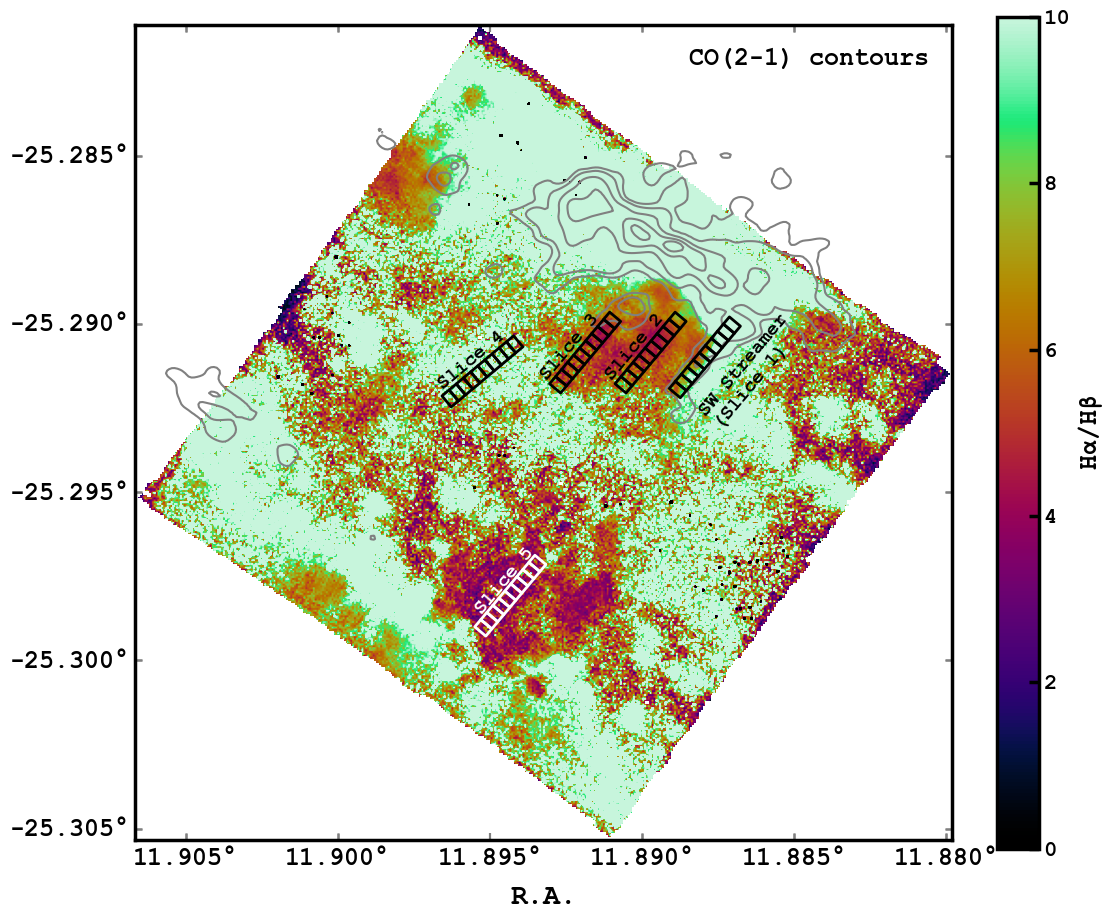

In [16]:
# cmap_NII = cmr.fusion_r
cmap_NII = cmr.get_sub_cmap('cmr.chroma', 0, 0.93)

# cmap_CO = cmr.neutral
# cmap_NII = cmr.neutral

# cmap_NII = cmr.get_sub_cmap('cmr.fusion_r', 0, 0.5)

# ============================================================================================================
# ============================================================================================================
CO21_cube = SpectralCube.read(COfilename)
CO21 = CO21_cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=restfreq)  
CO21_chan = CO21[53,:,:].to_value()
# CO21_mom0 = CO21.moment(order=0).to_value()  # moment 0
# CO21_mom1 = CO21.moment(order=1).to_value()
CO21w = CO21[0,:,:].wcs

plt.figure(figsize=(10,10))


# ============================================================================================================
# ============================================================================================================

ax = plt.subplot(1, 1, 1, projection=wcs.WCS(NII, naxis=2))
# ax = plt.subplot(1, 2, 2, projection=CO21w)
im = ax.imshow(1/rat_file[0].data, origin='lower', vmin=0, vmax=10, cmap=cmap_NII)
ax.set_title('', fontsize=18)
ax.coords[0].set_major_formatter('d.ddd')
ax.coords[1].set_major_formatter('d.ddd')
ax.coords[1].set_auto_axislabel(False)
ax.tick_params(axis='both', which='both',direction='in', width=1.5, labelsize=18, length=5, color='gray')
ax.set_xlabel('R.A.', fontsize=20)
# ax.set_xlim(140, 140+252)
# ax.set_ylim(175, 175+252)

ax.contour(CO21_chan, transform=ax.get_transform(CO21w),lw=5,
           levels=[-0.0223731, 0.1, 0.2, 0.606325, 1.23502, 1.86372, 2.49242], 
           colors='gray',zorder=0)
path1NII.show_on_axis(ax, spacing=5, edgecolor='black', linestyle='-',
                      linewidth=2)
path2NII.show_on_axis(ax, spacing=5, edgecolor='black', linestyle='-',
                      linewidth=2)
path3NII.show_on_axis(ax, spacing=5, edgecolor='black', linestyle='-',
                      linewidth=2)
path4NII.show_on_axis(ax, spacing=5, edgecolor='black', linestyle='-',
                      linewidth=2)
path5NII.show_on_axis(ax, spacing=5, edgecolor='white', linestyle='-',
                      linewidth=2)

bar = plt.colorbar(im, fraction=0.046)
bar.set_label(r'H$\alpha$/H$\beta$', fontsize=18)
bar.ax.tick_params(width=2.5, labelsize=16, length=7, direction='in')

at = AnchoredText('CO(2-1) contours', prop=Afont, frameon=False, 
                  loc='upper right')
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
# ax.set_facecolor('black')


# ============================================================================================================
# ============================================================================================================
    
# d12 = np.abs((coord2.separation(coord1).arcsec - (length1/2 + length2/2)))
# print('Difference between Slice1 and Slice2:', d12, 'arcsec')

# d23 = np.abs((coord3.separation(coord2).arcsec - (length2/2 + length3/2)))
# print('Difference between Slice2 and Slice3:', d23, 'arcsec')

plt.annotate('SW Streamer \n(Slice 1)', xy=(300, 220), fontsize=14, color='black', rotation=50)
plt.annotate('Slice 2', xy=(250, 246), fontsize=14, color='black', rotation=50)
plt.annotate('Slice 3', xy=(215, 246), fontsize=14, color='black', rotation=50)
plt.annotate('Slice 4', xy=(160, 241), fontsize=14, color='black', rotation=40)
plt.annotate('Slice 5', xy=(180, 121), fontsize=14, color='white', rotation=50)

plt.subplots_adjust(wspace=12, hspace=0)
plt.tight_layout()
# plt.savefig('../../ngc253/muse/visuals/se_co_outb_Dec8.png', bbox_inches='tight', dpi=200)
plt.show()